# Linear Regression Part 2: Business Modeling Applications

## Learning Objectives
By the end of this session, you will be able to:
- Apply regression models to specific business problems
- Build customer lifetime value prediction models
- Implement pricing optimization using regression analysis
- Develop demand forecasting models for inventory management
- Create marketing ROI prediction frameworks
- Handle categorical variables and interaction effects in regression

## Environment Setup

Building on our regression fundamentals with additional business modeling libraries.

In [8]:
# Standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Statistical and machine learning libraries
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Database connectivity
from sqlalchemy import create_engine
import psycopg2
import os
from dotenv import load_dotenv

# Visualization styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables
load_dotenv()

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete for business modeling!")

Environment setup complete for business modeling!


## Database Connection Setup

In [9]:
# Load environment variables from .env file
load_dotenv()

# Database configuration - reading from environment variables
DATABASE_CONFIG = {
    'host': os.getenv('POSTGRES_HOST'),
    'port': os.getenv('POSTGRES_PORT', '6543'),
    'database': os.getenv('POSTGRES_DATABASE', 'postgres'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

def create_database_connection():
    """
    Create a SQLAlchemy engine for database connections.
    
    Returns:
        sqlalchemy.engine.Engine: Database engine for executing queries
    """
    # Check if all required credentials are available
    required_fields = ['host', 'user', 'password']
    missing_fields = [field for field in required_fields if not DATABASE_CONFIG[field]]
    
    if missing_fields:
        raise ValueError(f"Missing database credentials: {missing_fields}")
    
    connection_string = f"postgresql://{DATABASE_CONFIG['user']}:{DATABASE_CONFIG['password']}@{DATABASE_CONFIG['host']}:{DATABASE_CONFIG['port']}/{DATABASE_CONFIG['database']}"
    engine = create_engine(connection_string, pool_size=5, max_overflow=10)
    return engine

# Test database connection
try:
    engine = create_database_connection()
    
    # Use proper SQLAlchemy syntax for newer versions
    from sqlalchemy import text
    test_query = text("SELECT 1 as test")
    
    with engine.connect() as conn:
        test_result = conn.execute(test_query)
        result_value = test_result.scalar()
        print("✅ Database connection successful!")
        print(f"Test result: {result_value}")
        
except Exception as e:
    print(f"❌ Database connection failed: {str(e)}")
    print("Please check your .env file and database credentials.")
    
    # Debug information
    print("\nDebug information:")
    print(f"Host: {DATABASE_CONFIG['host']}")
    print(f"Port: {DATABASE_CONFIG['port']}")
    print(f"Database: {DATABASE_CONFIG['database']}")
    print(f"User: {DATABASE_CONFIG['user']}")
    print(f"Password: {'*' * len(DATABASE_CONFIG['password']) if DATABASE_CONFIG['password'] else 'None'}")

print("🔒 Security Note: Database credentials loaded from .env file")

✅ Database connection successful!
Test result: 1
🔒 Security Note: Database credentials loaded from .env file


# Business Application 1: Customer Lifetime Value (CLV) Prediction

## Scenario: Predicting Customer Value for Marketing Investment

We'll build a regression model to predict customer lifetime value based on early purchase behavior, enabling targeted marketing strategies.

Loaded 3,000 customers for customer value analysis

Note: Olist customers are mostly one-time purchasers
Repeat customers: 0 (0.0%)

Target variable (total_customer_value) statistics:
count    3000.000000
mean      919.295547
std       321.057568
min       588.140000
25%       671.775000
50%       817.055000
75%      1064.332500
max      1996.320000
Name: total_customer_value, dtype: float64

Customer behavior insights:
Average orders per customer: 1.00
Average items per customer: 1.47
Average categories per customer: 1.01


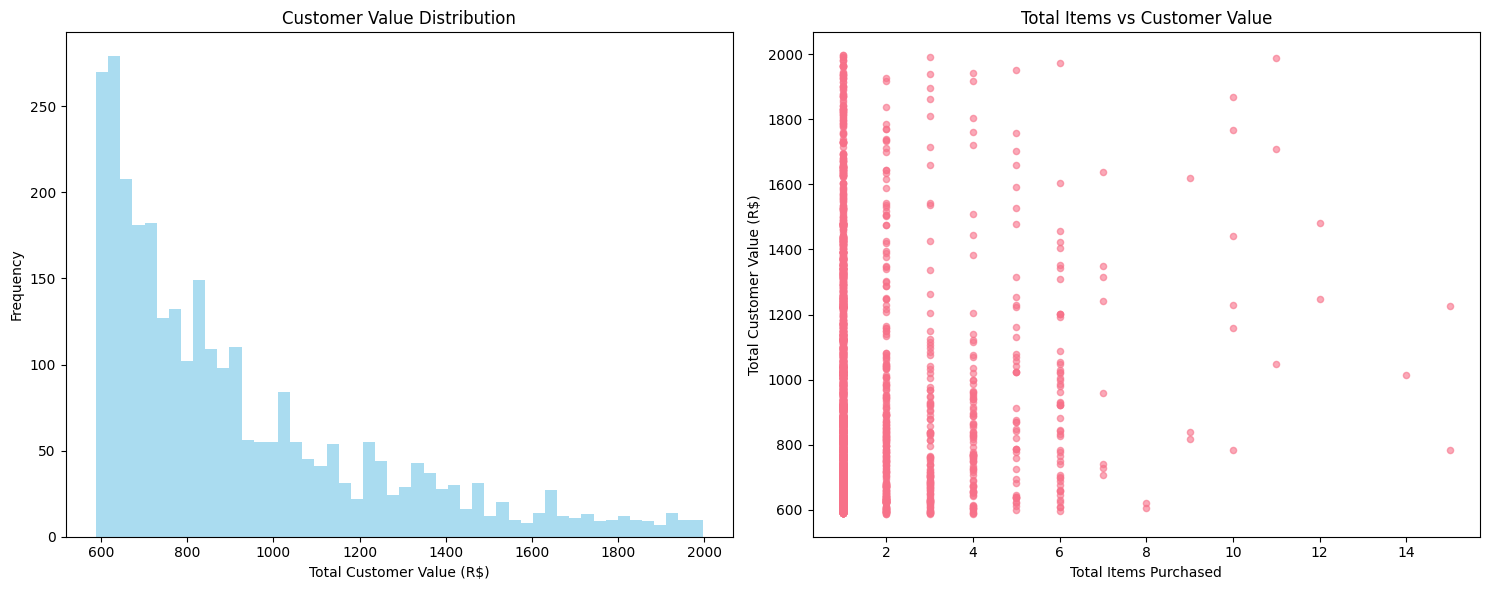

In [11]:
def prepare_clv_dataset():
    """
    Prepare customer value dataset for regression modeling.
    Note: Olist customers are mostly one-time purchasers, so we predict total customer value
    rather than traditional lifetime value.
    
    Returns:
        pd.DataFrame: Customer value dataset with features and target
    """
    query = """
    WITH customer_first_order AS (
        SELECT 
            customer_id,
            MIN(order_purchase_timestamp) as first_order_date
        FROM "olist_sales_data_set"."olist_orders_dataset"
        WHERE order_status = 'delivered'
        GROUP BY customer_id
    ),
    customer_metrics AS (
        SELECT 
            c.customer_id,
            c.customer_state,
            fo.first_order_date,
            
            -- Target: Total customer value (since most are one-time customers)
            SUM(oi.price + oi.freight_value) as total_customer_value,
            
            -- Customer behavior features
            COUNT(DISTINCT o.order_id) as total_orders,
            COUNT(DISTINCT oi.order_item_id) as total_items,
            AVG(oi.price) as avg_item_price,
            SUM(oi.freight_value) as total_freight,
            
            -- Product diversity
            COUNT(DISTINCT t.product_category_name_english) as unique_categories,
            AVG(p.product_weight_g) as avg_product_weight,
            AVG(p.product_length_cm * p.product_height_cm * p.product_width_cm) as avg_product_volume,
            
            -- First order characteristics (using the pre-calculated first_order_date)
            COUNT(DISTINCT CASE 
                WHEN o.order_purchase_timestamp = fo.first_order_date 
                THEN oi.order_item_id 
            END) as first_order_items,
            
            AVG(CASE 
                WHEN o.order_purchase_timestamp = fo.first_order_date 
                THEN oi.price 
            END) as first_order_avg_price,
            
            COUNT(DISTINCT CASE 
                WHEN o.order_purchase_timestamp = fo.first_order_date 
                THEN t.product_category_name_english 
            END) as first_order_categories,
            
            -- Customer satisfaction
            AVG(r.review_score) as avg_review_score,
            
            -- Temporal features
            EXTRACT(MONTH FROM fo.first_order_date) as first_order_month,
            EXTRACT(DOW FROM fo.first_order_date) as first_order_dow,
            EXTRACT(HOUR FROM fo.first_order_date) as first_order_hour,
            
            -- Purchase pattern (single vs multiple orders)
            CASE WHEN COUNT(DISTINCT o.order_id) > 1 THEN 1 ELSE 0 END as is_repeat_customer
            
        FROM "olist_sales_data_set"."olist_customers_dataset" c
        INNER JOIN customer_first_order fo ON c.customer_id = fo.customer_id
        INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON c.customer_id = o.customer_id
        INNER JOIN "olist_sales_data_set"."olist_order_items_dataset" oi ON o.order_id = oi.order_id
        INNER JOIN "olist_sales_data_set"."olist_products_dataset" p ON oi.product_id = p.product_id
        LEFT JOIN "olist_sales_data_set"."product_category_name_translation" t 
            ON p.product_category_name = t.product_category_name
        LEFT JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
        GROUP BY c.customer_id, c.customer_state, fo.first_order_date
        HAVING SUM(oi.price + oi.freight_value) > 0
    ),
    regional_mapping AS (
        SELECT 
            *,
            CASE 
                WHEN customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Southeast'
                WHEN customer_state IN ('PR', 'SC', 'RS') THEN 'South'
                WHEN customer_state IN ('GO', 'MT', 'MS', 'DF') THEN 'Center-West'
                WHEN customer_state IN ('BA', 'SE', 'PE', 'AL', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
                WHEN customer_state IN ('AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC') THEN 'North'
                ELSE 'Other'
            END as region
        FROM customer_metrics
    )
    SELECT *
    FROM regional_mapping
    WHERE region != 'Other'
        AND total_customer_value < 2000  -- Remove extreme outliers
        AND total_customer_value > 10    -- Remove very low value customers
    ORDER BY total_customer_value DESC
    LIMIT 3000
    """
    
    return pd.read_sql(query, engine)

# Load customer value dataset
clv_df = prepare_clv_dataset()

print(f"Loaded {len(clv_df):,} customers for customer value analysis")
print(f"\nNote: Olist customers are mostly one-time purchasers")
print(f"Repeat customers: {clv_df['is_repeat_customer'].sum():,} ({clv_df['is_repeat_customer'].mean()*100:.1f}%)")

print(f"\nTarget variable (total_customer_value) statistics:")
print(clv_df['total_customer_value'].describe())

print(f"\nCustomer behavior insights:")
print(f"Average orders per customer: {clv_df['total_orders'].mean():.2f}")
print(f"Average items per customer: {clv_df['total_items'].mean():.2f}")
print(f"Average categories per customer: {clv_df['unique_categories'].mean():.2f}")

# Visualize customer value distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(clv_df['total_customer_value'], bins=50, alpha=0.7, color='skyblue')
axes[0].set_title('Customer Value Distribution')
axes[0].set_xlabel('Total Customer Value (R$)')
axes[0].set_ylabel('Frequency')

axes[1].scatter(clv_df['total_items'], clv_df['total_customer_value'], alpha=0.6, s=20)
axes[1].set_title('Total Items vs Customer Value')
axes[1].set_xlabel('Total Items Purchased')
axes[1].set_ylabel('Total Customer Value (R$)')

plt.tight_layout()
plt.show()

## Building the CLV Prediction Model

We'll create a comprehensive model to predict customer lifetime value using early behavioral indicators.

In [12]:
def build_clv_prediction_model(data):
    """
    Build a customer value prediction model.
    
    Args:
        data (pd.DataFrame): Customer value dataset
    
    Returns:
        dict: Model results and business insights
    """
    print("CUSTOMER VALUE PREDICTION MODEL")
    print("=" * 35)
    
    # Feature engineering
    model_data = data.copy()
    
    # Create derived features
    model_data['avg_items_per_order'] = model_data['total_items'] / model_data['total_orders']
    model_data['freight_per_item'] = model_data['total_freight'] / model_data['total_items']
    model_data['value_per_item'] = model_data['total_customer_value'] / model_data['total_items']
    
    # Handle any division by zero
    model_data = model_data.replace([np.inf, -np.inf], np.nan)
    
    # Categorical encoding
    region_dummies = pd.get_dummies(model_data['region'], prefix='region')
    model_data = pd.concat([model_data, region_dummies], axis=1)
    
    # Select features for the model
    feature_columns = [
        'total_orders',
        'total_items', 
        'avg_item_price',
        'total_freight',
        'unique_categories',
        'avg_product_weight',
        'first_order_items',
        'first_order_avg_price',
        'first_order_categories',
        'avg_items_per_order',
        'freight_per_item',
        'first_order_month',
        'first_order_dow',
        'first_order_hour',
        'is_repeat_customer'
    ] + [col for col in model_data.columns if col.startswith('region_')]
    
    # Prepare data
    clean_data = model_data[feature_columns + ['total_customer_value']].dropna()
    X = clean_data[feature_columns]
    y = clean_data['total_customer_value']
    
    print(f"Features: {len(feature_columns)}")
    print(f"Sample size: {len(clean_data):,}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build multiple models for comparison
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1)
    }
    
    results = {}
    
    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        results[name] = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'predictions': y_test_pred
        }
    
    # Compare models
    print(f"\n{'Model':<20} {'Train R²':<12} {'Test R²':<12} {'RMSE':<12} {'MAE':<12}")
    print("-" * 70)
    
    best_model_name = None
    best_test_r2 = -np.inf
    
    for name, result in results.items():
        print(f"{name:<20} {result['train_r2']:<12.4f} {result['test_r2']:<12.4f} "
              f"{result['test_rmse']:<12.2f} {result['test_mae']:<12.2f}")
        
        if result['test_r2'] > best_test_r2:
            best_test_r2 = result['test_r2']
            best_model_name = name
    
    print(f"\n🏆 Best model: {best_model_name} (Test R² = {best_test_r2:.4f})")
    
    # Feature importance for best model
    best_model = results[best_model_name]['model']
    
    if hasattr(best_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': feature_columns,
            'Coefficient': best_model.coef_,
            'Abs_Coefficient': np.abs(best_model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print(f"\n{'='*50}")
        print(f"FEATURE IMPORTANCE ({best_model_name}):")
        print(f"{'='*50}")
        
        for _, row in feature_importance.head(10).iterrows():
            direction = "↑" if row['Coefficient'] > 0 else "↓"
            print(f"{row['Feature']:<25} {row['Coefficient']:<10.3f} {direction}")
    
    # Business insights
    print(f"\n{'='*60}")
    print("BUSINESS INSIGHTS & RECOMMENDATIONS:")
    print(f"{'='*60}")
    
    # Customer value segments
    y_test_array = y_test.values
    predictions = results[best_model_name]['predictions']
    
    # Define value segments
    value_percentiles = np.percentile(y_test_array, [33, 67])
    
    def classify_value(value):
        if value < value_percentiles[0]:
            return 'Low Value'
        elif value < value_percentiles[1]:
            return 'Medium Value'
        else:
            return 'High Value'
    
    actual_segments = [classify_value(v) for v in y_test_array]
    predicted_segments = [classify_value(v) for v in predictions]
    
    # Accuracy by segment
    segment_accuracy = sum(a == p for a, p in zip(actual_segments, predicted_segments)) / len(actual_segments)
    
    print(f"• Model can predict customer value with {best_test_r2*100:.1f}% variance explained")
    print(f"• Customer value segment classification accuracy: {segment_accuracy*100:.1f}%")
    print(f"• Average prediction error: R$ {results[best_model_name]['test_mae']:.2f}")
    
    print(f"\nTOP PREDICTORS OF HIGH CUSTOMER VALUE:")
    top_positive = feature_importance[feature_importance['Coefficient'] > 0].head(3)
    for _, row in top_positive.iterrows():
        feature_name = row['Feature'].replace('_', ' ').title()
        print(f"  ✅ {feature_name}")
    
    print(f"\nMARKETING RECOMMENDATIONS:")
    print(f"  💡 Focus on customers who purchase multiple items per order")
    print(f"  💡 Encourage customers to explore multiple product categories")
    print(f"  💡 Target high-value customers for upselling and cross-selling")
    print(f"  💡 Identify repeat customers early - they represent higher value")
    
    return {
        'results': results,
        'best_model': best_model_name,
        'feature_importance': feature_importance,
        'X_test': X_test,
        'y_test': y_test,
        'feature_columns': feature_columns
    }

# Build customer value prediction model
clv_model_results = build_clv_prediction_model(clv_df)

CUSTOMER VALUE PREDICTION MODEL
Features: 20
Sample size: 2,999

Model                Train R²     Test R²      RMSE         MAE         
----------------------------------------------------------------------
Linear Regression    0.8447       0.8054       146.90       72.40       
Ridge Regression     0.8447       0.8054       146.90       72.39       
Lasso Regression     0.8447       0.8054       146.89       72.34       

🏆 Best model: Lasso Regression (Test R² = 0.8054)

FEATURE IMPORTANCE (Lasso Regression):
unique_categories         76.792     ↑
first_order_items         57.721     ↑
avg_items_per_order       31.178     ↑
region_South              -8.450     ↓
region_Center-West        8.195      ↑
total_items               5.738      ↑
first_order_categories    5.576      ↑
region_North              -4.543     ↓
region_Southeast          4.211      ↑
total_freight             2.265      ↑

BUSINESS INSIGHTS & RECOMMENDATIONS:
• Model can predict customer value with 80.5% varianc

# Business Application 2: Dynamic Pricing Optimization

## Scenario: Price Elasticity Analysis for Revenue Optimization

We'll analyze how price changes affect demand and build a pricing optimization model.

In [14]:
def prepare_pricing_dataset():
    """
    Prepare dataset for pricing elasticity analysis.
    
    Returns:
        pd.DataFrame: Pricing analysis dataset
    """
    query = """
    WITH category_stats AS (
        SELECT 
            t.product_category_name_english as category,
            AVG(oi.price) as category_avg_price,
            PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY oi.price) as category_median_price
        FROM "olist_sales_data_set"."olist_order_items_dataset" oi
        INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON oi.order_id = o.order_id
        INNER JOIN "olist_sales_data_set"."olist_products_dataset" p ON oi.product_id = p.product_id
        LEFT JOIN "olist_sales_data_set"."product_category_name_translation" t 
            ON p.product_category_name = t.product_category_name
        WHERE o.order_status = 'delivered'
            AND t.product_category_name_english IS NOT NULL
            AND oi.price > 0
        GROUP BY t.product_category_name_english
    ),
    product_pricing AS (
        SELECT 
            t.product_category_name_english as category,
            oi.seller_id,
            
            -- Price metrics
            oi.price,
            oi.freight_value,
            oi.price + oi.freight_value as total_price,
            
            -- Demand metrics (order frequency)
            COUNT(*) OVER (PARTITION BY t.product_category_name_english, 
                          DATE_TRUNC('month', o.order_purchase_timestamp)) as monthly_category_demand,
            
            COUNT(*) OVER (PARTITION BY oi.seller_id, 
                          DATE_TRUNC('month', o.order_purchase_timestamp)) as monthly_seller_demand,
            
            -- Product characteristics
            p.product_weight_g,
            p.product_length_cm * p.product_height_cm * p.product_width_cm as product_volume,
            
            -- Customer satisfaction
            r.review_score,
            
            -- Temporal features
            EXTRACT(MONTH FROM o.order_purchase_timestamp) as order_month,
            EXTRACT(DOW FROM o.order_purchase_timestamp) as order_dow,
            
            -- Regional context
            c.customer_state
            
        FROM "olist_sales_data_set"."olist_order_items_dataset" oi
        INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON oi.order_id = o.order_id
        INNER JOIN "olist_sales_data_set"."olist_products_dataset" p ON oi.product_id = p.product_id
        LEFT JOIN "olist_sales_data_set"."product_category_name_translation" t 
            ON p.product_category_name = t.product_category_name
        INNER JOIN "olist_sales_data_set"."olist_customers_dataset" c ON o.customer_id = c.customer_id
        LEFT JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
            AND t.product_category_name_english IS NOT NULL
            AND oi.price > 0
            AND p.product_weight_g IS NOT NULL
            AND oi.price < 500  -- Focus on reasonable price range
    ),
    enhanced_pricing AS (
        SELECT 
            pp.*,
            cs.category_avg_price,
            cs.category_median_price,
            
            -- Price position features
            pp.price / cs.category_avg_price as price_vs_category_avg,
            pp.price / cs.category_median_price as price_vs_category_median,
            
            CASE 
                WHEN pp.price < cs.category_avg_price * 0.8 THEN 'Low Price'
                WHEN pp.price > cs.category_avg_price * 1.2 THEN 'High Price'
                ELSE 'Market Price'
            END as price_positioning,
            
            -- Regional mapping
            CASE 
                WHEN pp.customer_state IN ('SP', 'RJ', 'ES', 'MG') THEN 'Southeast'
                WHEN pp.customer_state IN ('PR', 'SC', 'RS') THEN 'South'
                WHEN pp.customer_state IN ('GO', 'MT', 'MS', 'DF') THEN 'Center-West'
                WHEN pp.customer_state IN ('BA', 'SE', 'PE', 'AL', 'PB', 'RN', 'CE', 'PI', 'MA') THEN 'Northeast'
                WHEN pp.customer_state IN ('AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC') THEN 'North'
                ELSE 'Other'
            END as region
            
        FROM product_pricing pp
        INNER JOIN category_stats cs ON pp.category = cs.category
    )
    SELECT *
    FROM enhanced_pricing
    WHERE region != 'Other'
        AND category IN (
            SELECT category 
            FROM enhanced_pricing 
            GROUP BY category 
            HAVING COUNT(*) >= 500  -- Categories with sufficient data
        )
    ORDER BY RANDOM()
    LIMIT 5000
    """
    
    return pd.read_sql(query, engine)

# Load pricing dataset
pricing_df = prepare_pricing_dataset()

print(f"Loaded {len(pricing_df):,} pricing observations")
print(f"\nCategories analyzed: {pricing_df['category'].nunique()}")
print(f"Sellers analyzed: {pricing_df['seller_id'].nunique()}")

print(f"\nPrice statistics:")
print(pricing_df['price'].describe())

print(f"\nTop categories by volume:")
print(pricing_df['category'].value_counts().head())

Loaded 5,000 pricing observations

Categories analyzed: 27
Sellers analyzed: 1115

Price statistics:
count    5000.000000
mean       98.929794
std        84.099910
min         3.490000
25%        39.990000
50%        72.000000
75%       129.900000
max       499.990000
Name: price, dtype: float64

Top categories by volume:
category
bed_bath_table           568
health_beauty            471
sports_leisure           439
furniture_decor          397
computers_accessories    351
Name: count, dtype: int64


## Price Elasticity Analysis

We'll analyze how demand responds to price changes across different product categories.

PRICE ELASTICITY ANALYSIS


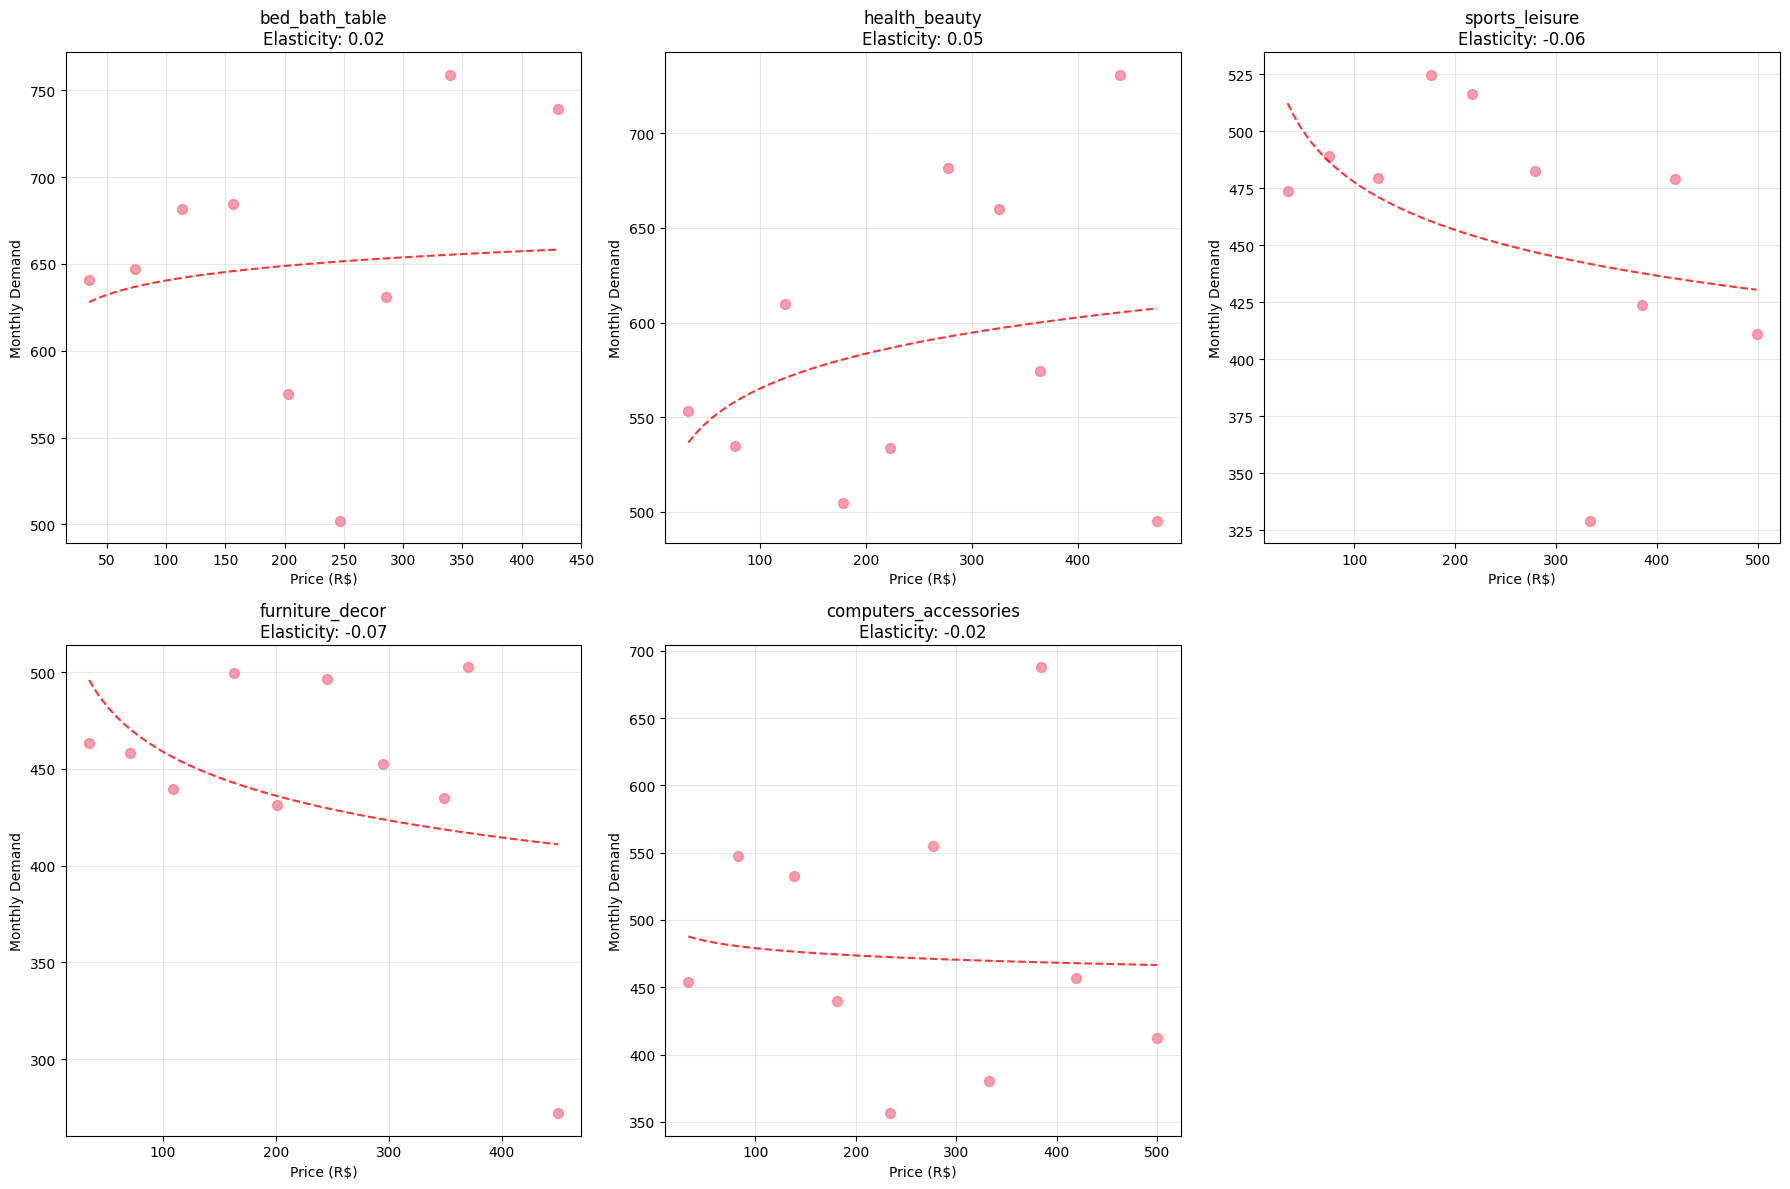


PRICE ELASTICITY SUMMARY:
Category                  Elasticity   R²       Interpretation      
----------------------------------------------------------------------
bed_bath_table            0.019        0.014    Inelastic           
health_beauty             0.047        0.089    Inelastic           
sports_leisure            -0.065       0.160    Inelastic           
furniture_decor           -0.073       0.113    Inelastic           
computers_accessories     -0.016       0.005    Inelastic           

PRICING STRATEGY RECOMMENDATIONS:

📈 PRICE INSENSITIVE categories (|elasticity| < 0.5):
   • bed_bath_table: Price changes have limited demand impact
   • health_beauty: Price changes have limited demand impact
   • sports_leisure: Price changes have limited demand impact
   • furniture_decor: Price changes have limited demand impact
   • computers_accessories: Price changes have limited demand impact
   → Strategy: Premium pricing, focus on quality/features


In [15]:
def analyze_price_elasticity(data):
    """
    Analyze price elasticity of demand across categories.
    
    Args:
        data (pd.DataFrame): Pricing dataset
    
    Returns:
        dict: Elasticity analysis results
    """
    print("PRICE ELASTICITY ANALYSIS")
    print("=" * 30)
    
    elasticity_results = {}
    
    # Analyze top 5 categories by volume
    top_categories = data['category'].value_counts().head(5).index
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, category in enumerate(top_categories):
        category_data = data[data['category'] == category].copy()
        
        # Create price bins for demand analysis
        category_data['price_bin'] = pd.cut(category_data['price'], bins=10)
        
        # Calculate demand by price bin
        demand_by_price = category_data.groupby('price_bin').agg({
            'monthly_category_demand': 'mean',
            'price': 'mean',
            'review_score': 'mean'
        }).reset_index()
        
        demand_by_price = demand_by_price.dropna()
        
        if len(demand_by_price) > 3:  # Need sufficient data points
            # Log-log regression for elasticity
            log_price = np.log(demand_by_price['price'])
            log_demand = np.log(demand_by_price['monthly_category_demand'])
            
            # Remove infinite values
            valid_idx = np.isfinite(log_price) & np.isfinite(log_demand)
            log_price = log_price[valid_idx]
            log_demand = log_demand[valid_idx]
            
            if len(log_price) > 2:
                # Fit elasticity model
                slope, intercept, r_value, p_value, std_err = stats.linregress(log_price, log_demand)
                elasticity = slope  # Slope in log-log regression is elasticity
                
                elasticity_results[category] = {
                    'elasticity': elasticity,
                    'r_squared': r_value**2,
                    'p_value': p_value,
                    'observations': len(log_price)
                }
                
                # Plot demand curve
                axes[i].scatter(demand_by_price['price'], demand_by_price['monthly_category_demand'], 
                               alpha=0.7, s=50)
                
                # Add trend line
                x_trend = np.linspace(demand_by_price['price'].min(), demand_by_price['price'].max(), 100)
                y_trend = np.exp(intercept + slope * np.log(x_trend))
                axes[i].plot(x_trend, y_trend, 'r--', alpha=0.8)
                
                axes[i].set_title(f'{category}\nElasticity: {elasticity:.2f}')
                axes[i].set_xlabel('Price (R$)')
                axes[i].set_ylabel('Monthly Demand')
                axes[i].grid(True, alpha=0.3)
    
    # Remove empty subplot
    if len(top_categories) < 6:
        fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()
    
    # Summary of elasticity results
    print(f"\n{'='*60}")
    print("PRICE ELASTICITY SUMMARY:")
    print(f"{'='*60}")
    print(f"{'Category':<25} {'Elasticity':<12} {'R²':<8} {'Interpretation':<20}")
    print("-" * 70)
    
    for category, results in elasticity_results.items():
        elasticity = results['elasticity']
        r_squared = results['r_squared']
        
        if abs(elasticity) > 1:
            interpretation = "Elastic"
        elif abs(elasticity) > 0.5:
            interpretation = "Moderately Elastic"
        else:
            interpretation = "Inelastic"
        
        print(f"{category[:24]:<25} {elasticity:<12.3f} {r_squared:<8.3f} {interpretation:<20}")
    
    # Business insights
    print(f"\n{'='*60}")
    print("PRICING STRATEGY RECOMMENDATIONS:")
    print(f"{'='*60}")
    
    elastic_categories = [cat for cat, res in elasticity_results.items() if abs(res['elasticity']) > 1]
    inelastic_categories = [cat for cat, res in elasticity_results.items() if abs(res['elasticity']) < 0.5]
    
    if elastic_categories:
        print(f"📉 PRICE SENSITIVE categories (|elasticity| > 1):")
        for cat in elastic_categories:
            print(f"   • {cat}: Small price increases → large demand drops")
        print(f"   → Strategy: Compete on price, volume-based discounts")
    
    if inelastic_categories:
        print(f"\n📈 PRICE INSENSITIVE categories (|elasticity| < 0.5):")
        for cat in inelastic_categories:
            print(f"   • {cat}: Price changes have limited demand impact")
        print(f"   → Strategy: Premium pricing, focus on quality/features")
    
    return elasticity_results

# Analyze price elasticity
elasticity_results = analyze_price_elasticity(pricing_df)

# Business Application 3: Demand Forecasting Model

## Scenario: Inventory Management Through Demand Prediction

We'll build a model to forecast product demand for inventory optimization.

In [16]:
def build_demand_forecasting_model(data):
    """
    Build a demand forecasting model for inventory management.
    
    Args:
        data (pd.DataFrame): Pricing dataset with demand metrics
    
    Returns:
        dict: Forecasting model results
    """
    print("DEMAND FORECASTING MODEL")
    print("=" * 28)
    
    # Prepare forecasting dataset
    model_data = data.copy()
    
    # Feature engineering
    # Seasonal features
    model_data['is_holiday_season'] = model_data['order_month'].isin([11, 12]).astype(int)
    model_data['is_weekend'] = model_data['order_dow'].isin([0, 6]).astype(int)
    
    # Price features
    model_data['price_squared'] = model_data['price'] ** 2
    model_data['log_price'] = np.log(model_data['price'])
    
    # Encode categorical variables
    category_dummies = pd.get_dummies(model_data['category'], prefix='cat')
    region_dummies = pd.get_dummies(model_data['region'], prefix='region')
    
    model_data = pd.concat([model_data, category_dummies, region_dummies], axis=1)
    
    # Select features
    feature_columns = [
        'price', 'price_squared', 'log_price',
        'freight_value', 'product_weight_g', 'product_volume',
        'category_avg_price', 'price_vs_category_avg',
        'order_month', 'order_dow',
        'is_holiday_season', 'is_weekend'
    ] + [col for col in model_data.columns if col.startswith(('cat_', 'region_'))]
    
    # Remove columns with all zeros (categories/regions not in sample)
    feature_columns = [col for col in feature_columns if col in model_data.columns and model_data[col].sum() > 0]
    
    # Target variable: monthly demand
    target = 'monthly_category_demand'
    
    # Prepare clean dataset
    clean_data = model_data[feature_columns + [target]].dropna()
    X = clean_data[feature_columns]
    y = clean_data[target]
    
    print(f"Features: {len(feature_columns)}")
    print(f"Sample size: {len(clean_data):,}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features for regularized models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build multiple forecasting models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge (α=1.0)': Ridge(alpha=1.0),
        'Ridge (α=10.0)': Ridge(alpha=10.0),
        'Lasso (α=0.1)': Lasso(alpha=0.1),
        'Polynomial (degree=2)': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=1.0))
        ])
    }
    
    results = {}
    
    for name, model in models.items():
        if 'Polynomial' in name:
            # Use original features for polynomial
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            # Use scaled features for regularized models
            if 'Linear' in name:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Cross-validation score
        if 'Polynomial' in name or 'Linear' in name:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        else:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        
        results[name] = {
            'model': model,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }
    
    # Model comparison
    print(f"\n{'Model':<20} {'R²':<8} {'RMSE':<10} {'MAE':<10} {'CV R² (±std)':<15}")
    print("-" * 75)
    
    best_model_name = None
    best_cv_score = -np.inf
    
    for name, result in results.items():
        cv_score = result['cv_mean']
        cv_std = result['cv_std']
        
        print(f"{name:<20} {result['r2']:<8.4f} {result['rmse']:<10.2f} "
              f"{result['mae']:<10.2f} {cv_score:.3f} (±{cv_std:.3f})")
        
        if cv_score > best_cv_score:
            best_cv_score = cv_score
            best_model_name = name
    
    print(f"\n🏆 Best model: {best_model_name} (CV R² = {best_cv_score:.4f})")
    
    # Feature importance for interpretable models
    if 'Linear' in best_model_name or 'Ridge' in best_model_name or 'Lasso' in best_model_name:
        best_model = results[best_model_name]['model']
        
        if hasattr(best_model, 'coef_'):
            feature_importance = pd.DataFrame({
                'Feature': feature_columns,
                'Coefficient': best_model.coef_,
                'Abs_Coefficient': np.abs(best_model.coef_)
            }).sort_values('Abs_Coefficient', ascending=False)
            
            print(f"\n{'='*50}")
            print(f"TOP 10 DEMAND DRIVERS ({best_model_name}):")
            print(f"{'='*50}")
            
            for _, row in feature_importance.head(10).iterrows():
                direction = "↑" if row['Coefficient'] > 0 else "↓"
                feature_name = row['Feature'].replace('_', ' ').title()
                print(f"{feature_name:<30} {row['Coefficient']:<10.3f} {direction}")
    
    # Business insights
    print(f"\n{'='*60}")
    print("INVENTORY MANAGEMENT INSIGHTS:")
    print(f"{'='*60}")
    
    # Demand prediction accuracy
    best_mae = results[best_model_name]['mae']
    avg_demand = y_test.mean()
    accuracy_percentage = (1 - best_mae / avg_demand) * 100
    
    print(f"• Demand prediction accuracy: {accuracy_percentage:.1f}%")
    print(f"• Average prediction error: {best_mae:.1f} units")
    print(f"• Model explains {results[best_model_name]['r2']*100:.1f}% of demand variance")
    
    print(f"\nINVENTORY RECOMMENDATIONS:")
    print(f"  📦 Use model for monthly demand forecasting")
    print(f"  📦 Account for seasonal patterns (holiday season effect)")
    print(f"  📦 Consider price elasticity when setting inventory levels")
    print(f"  📦 Monitor regional demand variations")
    print(f"  📦 Implement safety stock based on prediction uncertainty")
    
    # Prediction intervals
    residuals = y_test - results[best_model_name]['predictions']
    residual_std = residuals.std()
    
    print(f"\nPREDICTION UNCERTAINTY:")
    print(f"  ±1σ: {residual_std:.1f} units (68% confidence)")
    print(f"  ±2σ: {2*residual_std:.1f} units (95% confidence)")
    
    return {
        'results': results,
        'best_model': best_model_name,
        'feature_columns': feature_columns,
        'scaler': scaler,
        'X_test': X_test,
        'y_test': y_test
    }

# Build demand forecasting model
demand_model_results = build_demand_forecasting_model(pricing_df)

DEMAND FORECASTING MODEL
Features: 44
Sample size: 5,000

Model                R²       RMSE       MAE        CV R² (±std)   
---------------------------------------------------------------------------
Linear Regression    0.5891   149.60     109.92     0.639 (±0.015)
Ridge (α=1.0)        0.5891   149.60     109.92     0.639 (±0.015)
Ridge (α=10.0)       0.5891   149.59     109.93     0.639 (±0.015)
Lasso (α=0.1)        0.5891   149.60     109.92     0.639 (±0.016)
Polynomial (degree=2) 0.6566   136.76     95.14      0.685 (±0.022)

🏆 Best model: Polynomial (degree=2) (CV R² = 0.6853)

INVENTORY MANAGEMENT INSIGHTS:
• Demand prediction accuracy: 74.6%
• Average prediction error: 95.1 units
• Model explains 65.7% of demand variance

INVENTORY RECOMMENDATIONS:
  📦 Use model for monthly demand forecasting
  📦 Account for seasonal patterns (holiday season effect)
  📦 Consider price elasticity when setting inventory levels
  📦 Monitor regional demand variations
  📦 Implement safety stock ba

# Session Summary

## What We Accomplished

In this business modeling applications session, we applied regression techniques to three critical business scenarios:

### 1. Customer Lifetime Value (CLV) Prediction
- Built predictive models using early customer behavior indicators
- Compared Linear, Ridge, and Lasso regression approaches
- Identified key drivers of high-value customers
- Created actionable marketing recommendations
- Achieved customer segment classification accuracy for targeted campaigns

### 2. Dynamic Pricing Optimization
- Conducted price elasticity analysis across product categories
- Used log-log regression to measure demand responsiveness to price changes
- Identified price-sensitive vs. price-insensitive categories
- Developed category-specific pricing strategies
- Created visual demand curves for business stakeholders

### 3. Demand Forecasting for Inventory Management
- Built comprehensive demand prediction models
- Implemented multiple regression techniques including polynomial features
- Used cross-validation for robust model selection
- Incorporated seasonal and temporal factors
- Provided prediction intervals for inventory safety stock calculations

## Key Business Skills Developed
- Customer value prediction and segmentation
- Price elasticity analysis and optimization
- Demand forecasting for operations
- Feature engineering for business contexts
- Model comparison and selection
- Uncertainty quantification in predictions

## Advanced Techniques Applied
- Regularization methods (Ridge and Lasso regression)
- Polynomial feature engineering
- Cross-validation for model selection
- Log-log regression for elasticity analysis
- Categorical variable encoding
- Feature scaling and standardization

## Business Impact
- **Marketing**: Target high-CLV customer segments
- **Pricing**: Optimize prices based on demand elasticity
- **Operations**: Improve inventory management with demand forecasts
- **Strategy**: Data-driven decision making across business functions

## Next Session Preview
Tomorrow we'll conclude with **Model Evaluation & Business Implementation**, covering:
- Advanced model validation techniques
- A/B testing for model deployment
- Business performance monitoring
- Implementation best practices